# `nb08a`: Model checking

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now that we can simulate data and fit models, we can evaluate the quality of the model and critically assess whether it is a good fit to the data. This is called model checking.

# The light speed experiment 

Simon Newcomb did an experiment in 1882 to measure the speed of light. These are the times required for light to travel 7442 metres, recorded as deviations from 24,800 nanoseconds.

In [2]:
# data
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23]) 

In [3]:
# model
from scipy.stats import norm, uniform

def log_likelihood(theta, x):
    return norm.logpdf(x, loc=theta[0], scale=theta[1]).sum()

def log_prior(theta):   
    return (uniform.logpdf(theta[0], loc=-1000, scale=2000) +  # p(mu) = U[-1000, 1000]
            uniform.logpdf(theta[1], loc=0.1, scale=1000))      # p(sigma) = U[0.1, 1000]

def log_posterior(theta, x):
    return log_likelihood(theta, x) + log_prior(theta) 

In [4]:
# posterior inference
import emcee
pos = np.array([10.0, 10.0]) + 0.1 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(light_speed,))
sampler.run_mcmc(pos, 300000 // nwalkers, progress=True);

100%|██████████| 30000/30000 [00:58<00:00, 515.45it/s]


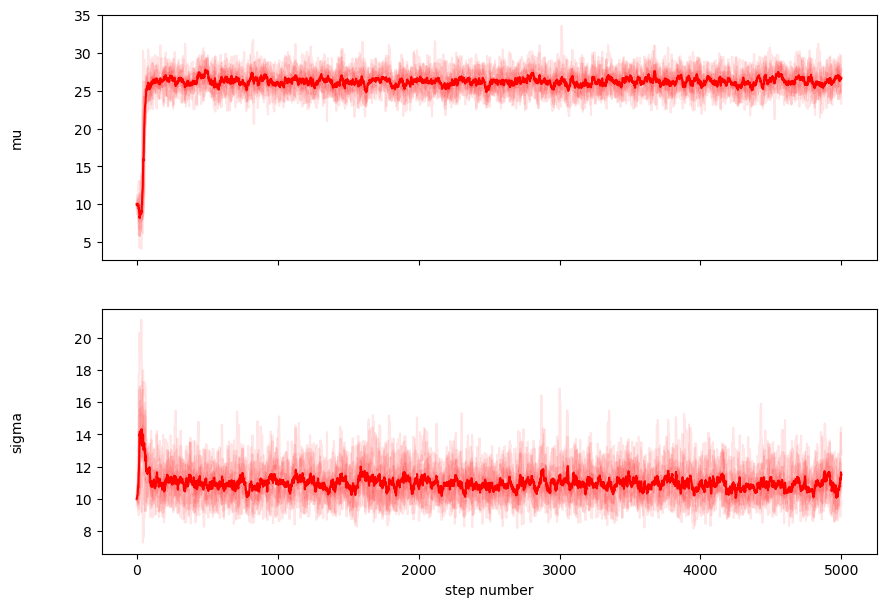

In [5]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:5000, :, i], "r", alpha=0.1)
    ax.plot(np.mean(samples[:5000, :, i], axis=1), "r", alpha=1.0)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [6]:
tau = sampler.get_autocorr_time()
tau

array([39.28864071, 35.09421728])

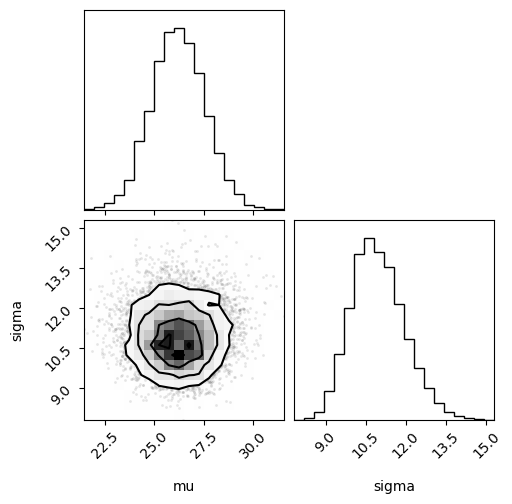

In [7]:
import corner
thetas = sampler.get_chain(flat=True, discard=500, thin=40)
fig = corner.corner(thetas, labels=labels)

In [8]:
print("E_p(mu|x)[mu] =", np.mean(thetas[:, 0]))
print("E_p(sigma|x)[sigma] =", np.mean(thetas[:, 1]))

E_p(mu|x)[mu] = 26.201728333470797
E_p(sigma|x)[sigma] = 10.960600260381204


In [9]:
print("Empirical mean =", np.mean(light_speed))
print("Empirical std =", np.std(light_speed))

Empirical mean = 26.21212121212121
Empirical std = 10.663610099255504


<div class="alert alert-success">
    
**Exercise**. Determine the 95% credibility interval for $\mu$ and $\sigma$.
    
</div>

In [10]:
def hpd(trace, mass_frac) :
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n-n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int+n_samples]])

low, high = hpd(thetas[:, 0], 0.95)
low, high

(23.5386806945586, 28.809097183344708)

In [11]:
24800+low, 24800+high

(24823.538680694557, 24828.809097183344)

Note: The currently accepted estimate of the speed of light under the conditions of the experiment corresponds to a measurement of 24833.02 nanoseconds.

# Posterior predictive distribution

$$p(x^\text{rep} | \{x\}) = \int p(x^\text{rep} | \theta) p(\theta | \{x\}) d\theta$$

In [12]:
thetas = thetas[:1000]

def pp(thetas):
    return norm.rvs(loc=thetas[:, 0], scale=thetas[:, 1])

$$p(\{x^\text{rep}\} | \{x\}) = \int p(\{x^\text{rep}\} | \theta) p(\theta | \{x\}) d\theta$$

In [13]:
def replicate(n_samples, thetas):
    x = np.zeros((n_samples, len(thetas)))
    
    for i in range(n_samples):
        x[i] = pp(thetas)
    
    return x

In [14]:
replicas = replicate(66, thetas)

In [15]:
replicas.shape

(66, 1000)

## Visual inspection of posterior predictives

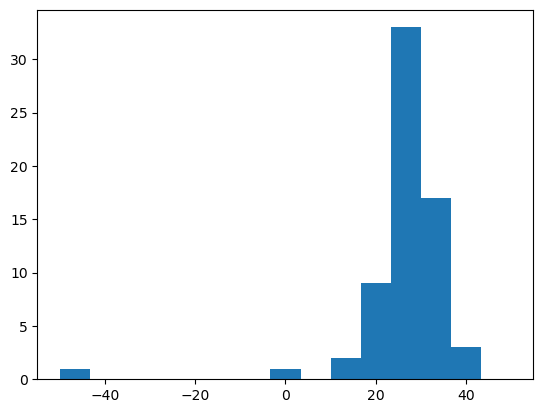

In [16]:
fig = plt.figure()
ax = plt.axes()
ax.hist(light_speed, bins=15, range=(-50, 50))
plt.show()

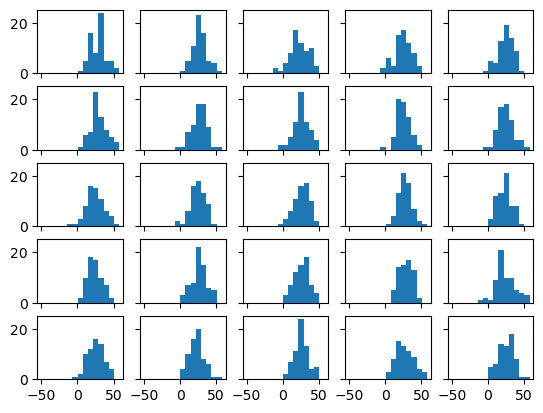

In [17]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
lower = -50
upper = np.max(replicas[:, :25])
for k in range(25):
    ax[k // 5, k % 5].hist(replicas[:, k], bins=15, range=(lower, upper))
plt.show()

## Test quantities

In [18]:
light_speed.min()

-44

In [19]:
replicas.min(axis=0)

array([ 2.11974027e+00,  7.40796276e+00, -1.15553600e+01, -2.28868612e+00,
        1.06547569e-01,  6.04376434e+00,  1.76111576e-01, -3.43371023e+00,
       -2.41509779e-01, -1.32947214e+00, -7.66243956e+00, -5.66748883e-01,
       -5.82814109e+00,  2.34917008e+00,  3.44225098e+00,  4.97097591e+00,
        5.74236476e+00,  2.32747765e+00,  8.48700203e+00, -1.05162275e+01,
       -4.64636718e+00,  1.89873963e+00,  6.07443778e+00,  6.44812011e+00,
        3.61995055e+00, -4.21186152e+00, -6.74578414e-01,  2.05703071e-02,
        5.37624293e+00, -4.37227213e+00, -8.94471262e-01,  5.49173075e-01,
       -7.98619416e+00, -5.11815015e+00, -2.59454202e+00, -1.61146903e+00,
       -4.20323957e+00,  1.56693114e+00,  1.24844398e+01,  7.20362963e+00,
        9.79700067e+00,  9.01962237e-01,  4.78452680e+00, -1.09629626e+01,
       -6.39252262e+00,  1.13125173e+01, -7.14062406e+00, -1.65222037e+00,
       -1.47431003e+01,  9.86484896e+00,  7.57048433e+00, -4.68671599e+00,
        3.09666486e+00, -

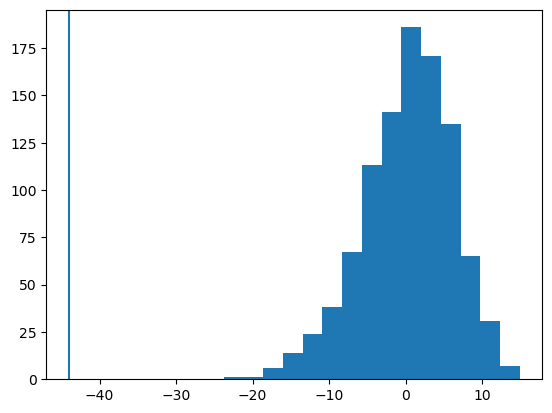

In [20]:
fig = plt.figure()
ax = plt.axes()

ax.hist(replicas.min(axis=0), bins=15)
ax.axvline(light_speed.min())
        
plt.show()

In [21]:
np.mean(replicas.min(axis=0) >= light_speed.min())

1.0

This suggests that the normal distribution is not adequate to model the data. Its tails are too light.

<div class="alert alert-success">
    
**Exercise**. Check whether the model is adequate using the empirical variance as a test quantity.
    
</div>

## Bayesian p-values

Formally,
- $T(\{x\}, \theta)$ denotes a test quantity or discrepancy measure.
- $T(\{x\})$ denotes a test-statistic.

Classical p-values:
$$p_C = P(T(\{x^\text{rep}\}) \geq T(\{x\}) | \theta)$$

Bayesian p-values:
$$p_B = P(T(\{x^\text{rep}\}, \theta) \geq T(\{x\}, \theta) | \{ x \})$$

In [22]:
def T(xs, theta):
    xs = np.sort(xs)
    return np.abs(xs[60] - theta) - np.abs(xs[5] - theta)  # should scatter around 0 for a symmetric distribution

In [23]:
T_reps = []
T_x = []

for k in range(len(thetas)):
    T_reps.append(T(replicas[:, k], thetas[k, 0]))
    T_x.append(T(light_speed, thetas[k, 0]))
    
T_reps = np.array(T_reps)
T_x = np.array(T_x)

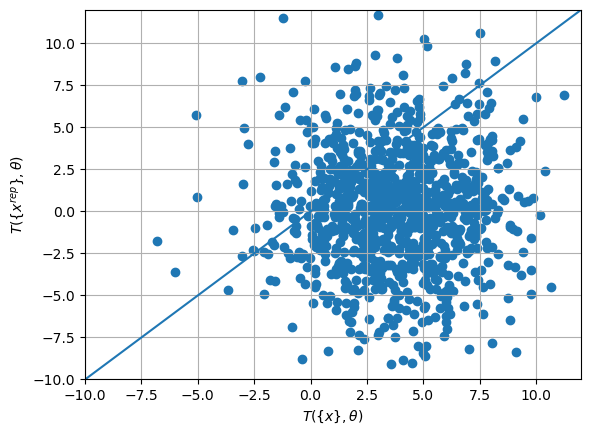

In [24]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(T_x, T_reps)
ax.plot([-10, 12], [-10, 12])
ax.set(xlim=(-10, 12), ylim=(-10,12), xlabel=r"$T(\{x\}, \theta)$", ylabel=r"$T(\{x^{rep}\}, \theta)$")
ax.grid()

plt.show()

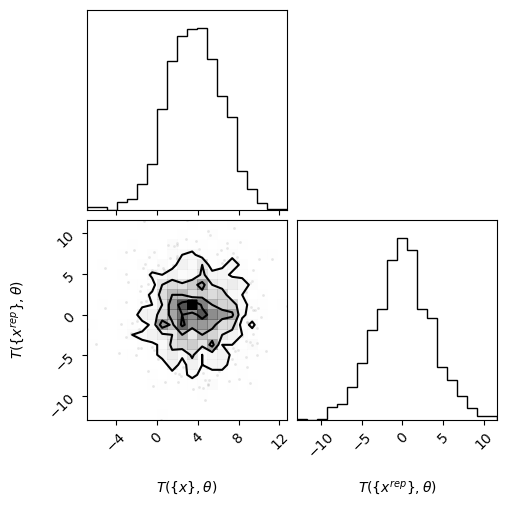

In [25]:
fig = corner.corner(np.hstack([T_x.reshape(-1, 1), T_reps.reshape(-1, 1)]), labels=[r"$T(\{x\}, \theta)$", r"$T(\{x^{rep}\}, \theta)$"])

In [26]:
np.mean(T_reps >= T_x)

0.205

_Gelman:_ "Finding an extreme p-value and thus ‘rejecting’ a model is
never the end of an analysis; the departures of the test quantity in
question from its posterior predictive distribution will often suggest
improvements of the model or places to check the data, as in the speed
of light example. Moreover, even when the current model seems
appropriate for drawing inferences (in that no unusual deviations
between the model and the data are found), the next scientific step will
often be a more rigorous experiment incorporating additional factors,
thereby providing better data."